In [1]:
%pip install datasets

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import os
import keras
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from keras import layers
from collections import defaultdict
from google.cloud import bigquery
import pickle

2024-05-21 07:12:11.417535: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-21 07:12:11.769706: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-21 07:12:13.089083: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
PROJECT_ID, DATASET_ID, TABLE_ID = "intern-project-415606", "Criminal_Dataset", "criminal_data_electra"
bigquery_client = bigquery.Client(project=PROJECT_ID)

In [10]:
# read the (original) data from the bigquery
def read_bq(project_id, dataset_id, table_id):

    query = f"""
        SELECT *
        FROM {project_id}.{dataset_id}.{table_id}
    """

    query_job = bigquery_client.query(query)

    # Convert the result into a Pandas DataFrame
    df = query_job.to_dataframe()

    return df

In [13]:
dataset = read_bq(PROJECT_ID, DATASET_ID, TABLE_ID)
dataset.head()

,extract_id,text,ner_label,sequence
0,4377,L,other,352
1,33225,gian,other,1690
2,17747,vi,other,5738
3,17747,có,other,15784
4,17750,vẫn,other,1861


In [3]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.ffn = keras.Sequential(
            [
                keras.layers.Dense(ff_dim, activation="relu"),
                keras.layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


In [4]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = keras.layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.pos_emb = keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, inputs):
        maxlen = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        position_embeddings = self.pos_emb(positions)
        token_embeddings = self.token_emb(inputs)
        return token_embeddings + position_embeddings

In [13]:
dataset

,extract_id,text,ner_label,sequence
0,597,<Page:1>TÒA,other,1
1,597,HÒA,other,6
2,597,XÃ,other,7
3,597,ạ,other,22
4,597,VIỆT,other,43
...,...,...,...,...
6542005,1666,Phú,other,2604
6542006,1666,-,I-ORGANIZATION,2606
6542007,1666,Phú,other,2611
6542008,1666,Những,other,2627


In [5]:
#mapping
label_map = {'[PAD]': 0,
            'other': 1,
            'I-ORGANIZATION': 2,
            'B-LOCATION': 3,
            'I-LOCATION': 4,
            'B-ORGANIZATION': 5,
            'B-PERSON': 6,
            'I-PERSON': 7,
            'B-MISCELLANEOUS': 8,
            'I-MISCELLANEOUS': 9}
label_map

{'[PAD]': 0,
 'other': 1,
 'I-ORGANIZATION': 2,
 'B-LOCATION': 3,
 'I-LOCATION': 4,
 'B-ORGANIZATION': 5,
 'B-PERSON': 6,
 'I-PERSON': 7,
 'B-MISCELLANEOUS': 8,
 'I-MISCELLANEOUS': 9}

In [15]:
# Replace numeric labels with NER labels
dataset.loc[:, 'ner_label'] = dataset['ner_label'].map(label_map)

dataset

,extract_id,text,ner_label,sequence
0,4377,L,1,352
1,33225,gian,1,1690
2,17747,vi,1,5738
3,17747,có,1,15784
4,17750,vẫn,1,1861
...,...,...,...,...
145463480,2244,nhận,1,1023
145463481,3837,nguyện,1,1972
145463482,794,án:,1,2021
145463483,823,Trung,1,514


In [ ]:
dataset['ner_label'].value_counts()

In [9]:
dataset.describe()

,extract_id,sequence
count,145463485.0,145463485.0
mean,18336.425521,2870.563136
std,10567.953637,3279.298332
min,0.0,1.0
25%,9172.0,996.0
50%,18409.0,2046.0
75%,27466.0,3573.0
max,36549.0,44559.0


In [16]:
agg_func = lambda x: list(x)
# Grouping the dataset by 'extract_id' and aggregating the 'text' and 'self_label' columns into lists
grouped_data = dataset.sort_values(['extract_id', 'sequence']).groupby('extract_id').agg({'text': agg_func, 'ner_label': agg_func, 'sequence': agg_func}).reset_index()
# Converting the grouped data into a dictionary
dataset_group = {
    'id': grouped_data['extract_id'].tolist(),
    'token': grouped_data['text'].tolist(),
    'ner_label': grouped_data['ner_label'].tolist(),
    'seq': grouped_data['sequence'].tolist()
}

# Printing the first group for verification
print('Group ID:', dataset_group['id'][1])
print('Token:', len(dataset_group['token'][1]))
print('NER Tag:',len(dataset_group['ner_label'][1]))
print('seq:', len(dataset_group['seq'][1]))

Group ID: 1
Token: 3391
NER Tag: 3391
seq: 3391


In [17]:
def split_into_chunks(lst, chunk_size):
    """Splits a list into smaller chunks of a specified size."""
    for i in range(0, len(lst), chunk_size):
        yield lst[i:i + chunk_size]

# Initialize a new dataset dictionary
split_dataset = {
    'id': [],
    'token': [],
    'ner_label': []
}

# Iterate over each group in the original grouped dataset
for idx, (group_id, tokens, labels) in enumerate(zip(dataset_group['id'], dataset_group['token'], dataset_group['ner_label'])):
    # Split tokens and labels into chunks of 512
    token_chunks = list(split_into_chunks(tokens, 512))
    label_chunks = list(split_into_chunks(labels, 512))

    # Add each chunk to the new dataset dictionary
    for chunk_idx in range(len(token_chunks)):
        split_dataset['id'].append(group_id)  # Keep the same group_id for each chunk
        split_dataset['token'].append(token_chunks[chunk_idx])
        split_dataset['ner_label'].append(label_chunks[chunk_idx])

# Print the first chunk for verification
print('Group ID:', split_dataset['id'][0])
print('Token:', split_dataset['token'][0])
print('NER Tag:', split_dataset['ner_label'][0])


Group ID: 0
Token: ['<Page:1>TÒA', 'ÁN', 'NHÂN', 'DÂN', 'CỘNG', 'HÒA', 'XÃ', 'HỘI', 'CHỦ', 'NGHĨA', 'VIỆT', 'NAM', 'HUYỆN', 'ANH', 'SƠN', 'Độc', 'lập', '–', 'Tự', 'do', '–', 'Hạnh', 'phúc', 'TỈNH', 'NGHỆ', 'AN', 'Số:', '17/QĐ', '–', 'TA', 'Anh', 'Sơn,', 'ngày', '18', 'tháng', '5', 'năm', '2021', 'QUYẾT', 'ĐỊNH', 'Áp', 'dụng', 'biện', 'pháp', 'xử', 'lý', 'hành', 'chính', 'đưa', 'và', 'cơ', 'sở', 'cai', 'nghiện', 'bắt', 'buộc', 'TÒA', 'ÁN', 'NHÂN', 'DÂN', 'HUYỆN', 'ANH', 'SƠN,', 'TỈNH', 'NGHỆ', 'AN', 'Với', 'thành', 'phần', 'tiến', 'hành', 'phiên', 'họp', 'gồm', 'có:', '1.', 'Thẩm', 'phán:', 'Ông', 'Phan', 'Văn', 'Phú', '2.', 'Thư', 'ký', 'phiên', 'họp:', 'Ông', 'Phạm', 'Mạnh', 'Cường', 'Ngày', '18', 'tháng', '5', 'năm', '2021,', 'tại', 'trụ', 'sở', 'Tòa', 'án', 'nhân', 'dân', 'huyện', 'A,', 'tỉnh', 'N', 'tiến', 'hành', 'phiên', 'họp', 'xem', 'xét,', 'quyết', 'định', 'áp', 'dụng', 'biện', 'pháp', 'xử', 'lý', 'hành', 'chính', 'đưa', 'vào', 'cơ', 'sở', 'cai', 'nghiện', 'bắt', 'buộc', 'theo

Average length: 3979.8491108071134
Highest length: 44559
Average length of each sublist: 3979.8491108071134
Median for sublist lengths: 3322.0
Maximum length of each sublist: 44559
Percentage of data less than length of 5000: 78.78522571819425


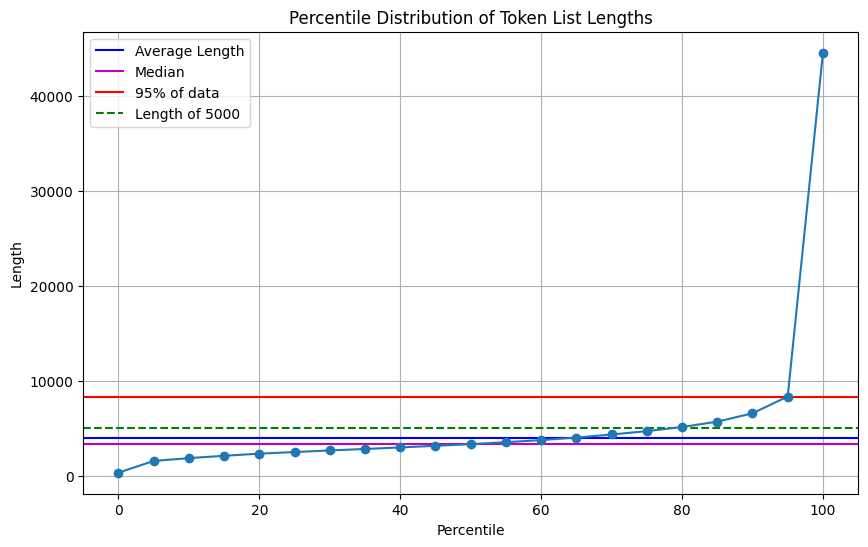

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate average length and highest length of token lists in dataset_group
total_length, highest_length = 0, 0
for token_list in dataset_group['token']:
    # Calculate the length of the current token list
    length = len(token_list)

    # Update total length
    total_length += length

    # Update highest length if necessary
    if length > highest_length:
        highest_length = length

# Calculate average length
if dataset_group['token']:
    average_length = total_length / len(dataset_group['token'])
else:
    average_length = 0

print("Average length:", average_length)
print("Highest length:", highest_length)

# Plotting percentile distribution of token list lengths
lengths = [len(sublist) for sublist in dataset_group['token']]
percentiles = np.arange(0, 101, 5)
percentile_values = np.percentile(lengths, percentiles)
avg_lengths = np.mean(lengths)
quartiles = np.percentile(lengths, [25, 50, 75])
max_lengths = max(lengths)
percentage_less_than_5000 = np.mean(np.array(lengths) <= 5000) * 100

print("Average length of each sublist:", avg_lengths)
print("Median for sublist lengths:", quartiles[1])
print("Maximum length of each sublist:", max_lengths)
print("Percentage of data less than length of 5000:", percentage_less_than_5000)

plt.figure(figsize=(10, 6))
plt.axhline(y=avg_lengths, color='b', linestyle='-', label='Average Length')
plt.axhline(y=quartiles[1], color='m', linestyle='-', label='Median')
plt.axhline(y=percentile_values[-2], color='r', linestyle='-', label='95% of data')
plt.axhline(y=5000, color='g', linestyle='--', label='Length of 5000')  # Added line for length 256
plt.plot(percentiles, percentile_values, marker='o', linestyle='-')
plt.xlabel('Percentile')
plt.ylabel('Length')
plt.title('Percentile Distribution of Token List Lengths')
plt.grid(True)
plt.legend()
plt.show()


Average length: 481.2385160238066
Highest length: 512
Average length of each sublist: 481.2385160238066
Median for sublist lengths: 512.0
Maximum length of each sublist: 512
Percentage of data less than length of 5000: 100.0


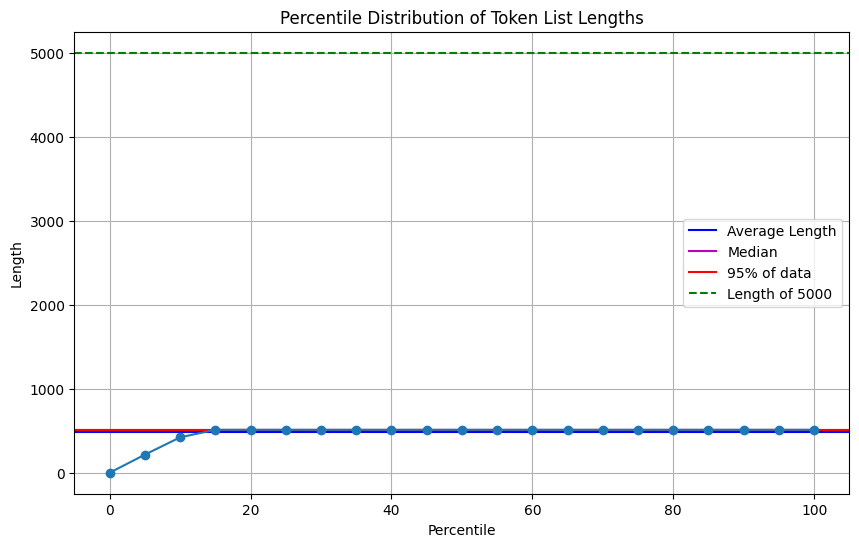

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate average length and highest length of token lists in dataset_group
total_length, highest_length = 0, 0
for token_list in split_dataset['token']:
    # Calculate the length of the current token list
    length = len(token_list)

    # Update total length
    total_length += length

    # Update highest length if necessary
    if length > highest_length:
        highest_length = length

# Calculate average length
if dataset_group['token']:
    average_length = total_length / len(split_dataset['token'])
else:
    average_length = 0

print("Average length:", average_length)
print("Highest length:", highest_length)

# Plotting percentile distribution of token list lengths
lengths = [len(sublist) for sublist in split_dataset['token']]
percentiles = np.arange(0, 101, 5)
percentile_values = np.percentile(lengths, percentiles)
avg_lengths = np.mean(lengths)
quartiles = np.percentile(lengths, [25, 50, 75])
max_lengths = max(lengths)
percentage_less_than_5000 = np.mean(np.array(lengths) <= 5000) * 100

print("Average length of each sublist:", avg_lengths)
print("Median for sublist lengths:", quartiles[1])
print("Maximum length of each sublist:", max_lengths)
print("Percentage of data less than length of 5000:", percentage_less_than_5000)

plt.figure(figsize=(10, 6))
plt.axhline(y=avg_lengths, color='b', linestyle='-', label='Average Length')
plt.axhline(y=quartiles[1], color='m', linestyle='-', label='Median')
plt.axhline(y=percentile_values[-2], color='r', linestyle='-', label='95% of data')
plt.axhline(y=5000, color='g', linestyle='--', label='Length of 5000')  # Added line for length 256
plt.plot(percentiles, percentile_values, marker='o', linestyle='-')
plt.xlabel('Percentile')
plt.ylabel('Length')
plt.title('Percentile Distribution of Token List Lengths')
plt.grid(True)
plt.legend()
plt.show()

In [19]:
dataset_group = split_dataset

In [15]:
# drop the data > 5000
print("Number of remaining entries before filtering:", len(dataset_group['id']))
# Create empty lists to store filtered data
filtered_ids = []
filtered_tokens = []
filtered_self_tags = []

# Iterate through the token lists and their corresponding ids and self_tags
for id, token_list, self_tag_list in zip(dataset_group['id'], dataset_group['token'], dataset_group['ner_label']):
    # Check if the length of the token list is less than or equal to 1024
    if len(token_list) <= 5000:
        # If the length is within the limit, append the id, token list, and self tag list to the filtered lists
        filtered_ids.append(id)
        filtered_tokens.append(token_list)
        filtered_self_tags.append(self_tag_list)

# Update the dataset_group dictionary with the filtered lists
dataset_group['id'] = filtered_ids
dataset_group['token'] = filtered_tokens
dataset_group['ner_label'] = filtered_self_tags

# Print the lengths after filtering
print("Number of remaining entries after filtering:", len(dataset_group['id']))


Number of remaining entries before filtering: 302269
Number of remaining entries after filtering: 302269


In [20]:
from sklearn.model_selection import train_test_split

from datasets import Dataset, DatasetDict

# Assuming dataset_group is already constructed as in your previous code

# Convert dataset_group to a DataFrame
import pandas as pd
dataset_df = pd.DataFrame(dataset_group)

# Split data into train and test sets
train_df, test_df = train_test_split(dataset_df, test_size=0.2, random_state=42)

# Create train and test datasets
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Construct DatasetDict
dataset_dict = DatasetDict({'train': train_dataset, 'test': test_dataset})

# Print DatasetDict
print(dataset_dict)

DatasetDict({
    train: Dataset({
        features: ['id', 'token', 'ner_label', '__index_level_0__'],
        num_rows: 241815
    })
    test: Dataset({
        features: ['id', 'token', 'ner_label', '__index_level_0__'],
        num_rows: 60454
    })
})


In [25]:
print(type(dataset_dict['train']['ner_label'][0][0]))

<class 'int'>


In [17]:
def export_to_file(export_file_path, data):
    with open(export_file_path, "w") as f:
        for record in data:
            ner_tags = record["ner_label"]
            tokens = record["token"]
            if len(tokens) > 0:
                f.write(
                    str(len(tokens))
                    + "\t"
                    + "\t".join(tokens)
                    + "\t"
                    + "\t".join(map(str, ner_tags))
                    + "\n"
                )
try:
    os.mkdir('./data')
except:
    print('directory exist')
export_to_file("./data/crime_train.txt", dataset_dict['train'])
export_to_file("./data/crime_val.txt", dataset_dict['test'])

directory exist


In [6]:
def make_tag_lookup_table():
    ner_labels = {'[PAD]': 0,
                  'other': 1,
                  'I-ORGANIZATION': 2,
                  'B-LOCATION': 3,
                  'I-LOCATION': 4,
                  'B-ORGANIZATION': 5,
                  'B-PERSON': 6,
                  'I-PERSON': 7,
                  'B-MISCELLANEOUS': 8,
                  'I-MISCELLANEOUS': 9}
    return dict(zip(range(len(ner_labels)), ner_labels))

mapping = make_tag_lookup_table()
print(mapping)

{0: '[PAD]', 1: 'other', 2: 'I-ORGANIZATION', 3: 'B-LOCATION', 4: 'I-LOCATION', 5: 'B-ORGANIZATION', 6: 'B-PERSON', 7: 'I-PERSON', 8: 'B-MISCELLANEOUS', 9: 'I-MISCELLANEOUS'}


In [19]:
s = 0
for d in dataset_dict['train']['token']:
    s += len(d)
print(s)

116394994


In [ ]:
def generate_tokens(dataset):
    for tokens in dataset:
        for token in tokens:
            yield token

def count_tokens(token_generator):
    token_counter = defaultdict(int)
    for token in token_generator:
        token_counter[token] += 1
    return token_counter

token_generator = generate_tokens(dataset_dict["train"]["token"])
counter = count_tokens(token_generator)

print(len(counter))

num_tags = len(mapping)
vocab_size = 460000

# Sort the items in the defaultdict by value (count), in descending order
sorted_items = sorted(counter.items(), key=lambda item: item[1], reverse=True)

# Take the (vocab_size - 2) most common tokens
vocabulary = [token for token, count in sorted_items[:vocab_size - 2]]

# Save the list to a file
with open('./data/vocabulary.pkl', 'wb') as f:
    pickle.dump(vocabulary, f)

# The StringLookup class will convert tokens to token IDs
lookup_layer = keras.layers.StringLookup(vocabulary=vocabulary)

543449


In [7]:
with open('./data/vocabulary.pkl', 'rb') as f:
    loaded_list = pickle.load(f)
    # The StringLookup class will convert tokens to token IDs
lookup_layer = keras.layers.StringLookup(vocabulary=loaded_list)

In [8]:
train_data = tf.data.TextLineDataset("./data/crime_train.txt")
val_data = tf.data.TextLineDataset("./data/crime_val.txt")

In [ ]:
#print(list(train_data.take(1).as_numpy_iterator()))

In [9]:
@keras.utils.register_keras_serializable(package='CustomModels')
class NERModel(keras.Model):
    def __init__(
        self, num_tags, vocab_size, maxlen=512, embed_dim=256, num_heads=2, ff_dim=32, **kwargs
    ):
        super().__init__()
        self.num_tags = num_tags
        self.vocab_size = vocab_size
        self.maxlen = maxlen
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim

        self.embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
        self.transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
        self.dropout1 = layers.Dropout(0.1)
        self.ff = layers.Dense(ff_dim, activation="relu")
        self.dropout2 = layers.Dropout(0.1)
        self.ff_final = layers.Dense(num_tags, activation="softmax")

    def call(self, inputs, training=False):
        x = self.embedding_layer(inputs)
        x = self.transformer_block(x)
        x = self.dropout1(x, training=training)
        x = self.ff(x)
        x = self.dropout2(x, training=training)
        x = self.ff_final(x)
        return x

    def get_config(self):
        config = {
            'num_tags': self.num_tags,
            'vocab_size': self.vocab_size,
            'maxlen': self.maxlen,
            'embed_dim': self.embed_dim,
            'num_heads': self.num_heads,
            'ff_dim': self.ff_dim,
        }
        base_config = super(NERModel, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [16]:
def map_record_to_training_data(record):
    record = tf.strings.split(record, sep="\t")
    length = tf.strings.to_number(record[0], out_type=tf.int32)
    tokens = record[1 : length + 1]
    tags = record[length + 1 :]
    tags = tf.strings.to_number(tags, out_type=tf.int64)
    
    return tokens, tags


def convert_to_ids(tokens):
    return lookup_layer(tokens)

# We use `padded_batch` here because each record in the dataset has a
# different length.
batch_size = 64

train_dataset = (
    train_data.map(map_record_to_training_data)
    .map(lambda x, y: (lookup_layer(x), y))
    .padded_batch(batch_size)
)
val_dataset = (
    val_data.map(map_record_to_training_data)
    .map(lambda x, y: (lookup_layer(x), y))
    .padded_batch(batch_size)
)
num_tags = len(mapping)
vocab_size = 500000
ner_model = NERModel(num_tags, vocab_size, embed_dim=256, num_heads=4, ff_dim=64)

In [17]:
for a, b in train_dataset:
    print(a)
    print(len(b[0]))
    break

tf.Tensor(
[[  1746   2064   1776 ...    266    218    584]
 [   356    741     60 ...     53      7      1]
 [    15   1601   5894 ...    240 163024    221]
 ...
 [   933    383    279 ...  29248     67     74]
 [   334    234     15 ...     60     66    737]
 [ 20481     15     67 ...    217     58     28]], shape=(64, 512), dtype=int64)
512


In [18]:
from tensorflow.keras.losses import Reduction

class CustomNonPaddingTokenLoss(keras.losses.Loss):
    def __init__(self, reduction='sum', name="custom_ner_loss"):
        super().__init__(reduction=reduction, name=name)

    def call(self, y_true, y_pred):
        loss_fn = keras.losses.SparseCategoricalCrossentropy(
            from_logits=False, reduction=self.reduction  # Pass the reduction argument here
        )
        loss = loss_fn(y_true, y_pred)
        mask = tf.cast((y_true > 0), dtype=tf.float32)
        loss = loss * mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

loss = CustomNonPaddingTokenLoss()


In [ ]:
from keras.losses import SparseCategoricalCrossentropy

# Compile the model with a specified loss function and optimizer
ner_model.compile(optimizer="adam", loss=loss)
ner_model.fit(train_dataset, epochs=10)

Epoch 1/10
   1978/Unknown 6981s 4s/step - loss: 6210.0649

In [ ]:
ner_model.save("ner_model_electra.keras")